## General Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
from tqdm import tqdm
import seaborn as sns
import time
import math
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
import timeit
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm
import torch
import torch.nn as nn
import itertools
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
from typing import Tuple, Dict, List
import warnings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
from tqdm import tqdm
import seaborn as sns
import time
import math
from scipy.stats import pearsonr


In [2]:
def GetTBModelDerivatives(y, lamda, mu):
    N = (lamda/mu) + 1
    params = [
    lamda/N,         # lambda (recruitment rate)
    0.025,     # beta (transmission rate)
    1,         # delta (differential infectivity)
    0.3,       # p (fraction that goes directly to infectious)
    mu,    # mu (natural death rate)
    0.005,     # k (progression rate from exposed to infectious)
    0,         # r1 (early treatment effectiveness, not used here)
    0.8182,    # r2 (treatment rate of infectious)
    0.02,      # phi (rate from I to L)
    0.01,      # gamma (reactivation from L to I)
    0.0227,    # d1 (death rate from I)
    0.20       # d2 (death rate from L)
    ]
    S, E, I, L = y
    λ, β, δ, p, μ, k, r1, r2, φ, γ, d1, d2 = params

    dSdt = λ - β * S * (I + δ * L) * N - μ * S
    dEdt = β * (1 - p) * S * (I + δ * L) * N + r2 * I - (μ + k * (1 - r1)) * E
    dIdt = β * p * S * (I + δ * L) * N + k * (1 - r1) * E + γ * L - (μ + d1 + φ * (1 - r2) + r2) * I
    dLdt = φ * (1 - r2) * I - (μ + d2 + γ) * L

    if(torch.is_tensor(dSdt)):
      return dSdt, dEdt, dIdt, dLdt
    else:
      return np.array([dSdt, dEdt, dIdt, dLdt])

def GetTBModelDerivativesForSolveIVP(t, y, lamda, mu):
    N = (lamda/mu) + 1
    params = [
    lamda/N,         # lambda (recruitment rate)
    0.025,     # beta (transmission rate)
    1,         # delta (differential infectivity)
    0.3,       # p (fraction that goes directly to infectious)
    mu,    # mu (natural death rate)
    0.005,     # k (progression rate from exposed to infectious)
    0,         # r1 (early treatment effectiveness, not used here)
    0.8182,    # r2 (treatment rate of infectious)
    0.02,      # phi (rate from I to L)
    0.01,      # gamma (reactivation from L to I)
    0.0227,    # d1 (death rate from I)
    0.20       # d2 (death rate from L)
    ]
    S, E, I, L = y
    λ, β, δ, p, μ, k, r1, r2, φ, γ, d1, d2 = params

    dSdt = λ - β * S * (I + δ * L) * N - μ * S
    dEdt = β * (1 - p) * S * (I + δ * L) * N + r2 * I - (μ + k * (1 - r1)) * E
    dIdt = β * p * S * (I + δ * L) * N + k * (1 - r1) * E + γ * L - (μ + d1 + φ * (1 - r2) + r2) * I
    dLdt = φ * (1 - r2) * I - (μ + d2 + γ) * L

    if(torch.is_tensor(dSdt)):
      return torch.stack([dSdt, dEdt, dIdt, dLdt])
    else:
      return np.array([dSdt, dEdt, dIdt, dLdt])

def runge_kutta_4(f, y0, t, lamda, mu):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(1, n):
        h = t[i] - t[i - 1]
        k1 = f(y[i - 1], lamda, mu)
        k2 = f(y[i - 1] + h/2 * k1, lamda, mu)
        k3 = f(y[i - 1] + h/2 * k2, lamda, mu)
        k4 = f(y[i - 1] + h * k3, lamda, mu)
        y[i] = y[i - 1] + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
    return y

In [3]:
def generate_rk_solution(time_true, lamda, mu):
  time_true = np.array(time_true).flatten()
  S = lamda / mu
  N = S + 1
  y0 = [S/N, 1/N, 0, 0]

  solution = runge_kutta_4(GetTBModelDerivatives, y0, time_true, lamda, mu)
  S_true, E_true, I_true, L_true = solution.T
  data = {
    'Time':time_true,
    'S': S_true,
    'E': E_true,
    'I': I_true,
    'L': L_true
}

  # Create DataFrame
  df = pd.DataFrame(data)
  return df


def generate_reference_solution(time_true, lamda, mu):
  time_true = np.array(time_true).flatten()
  S = lamda / mu
  N = S + 1
  y0 = [S/N, 1/N, 0, 0]
  solution = solve_ivp(GetTBModelDerivativesForSolveIVP, [0,20], y0, method="LSODA", args = (lamda, mu), t_eval=time_true)
  data = {
    'Time':solution.t,
    'S': solution.y[0],
    'E': solution.y[1],
    'I': solution.y[2],
    'L': solution.y[3]
  }

  # Create DataFrame
  df = pd.DataFrame(data)
  return df


def CalculateMSEDifferentTimes(S, E, I, L, t_sim):
    df = generate_reference_solution()
    t_ref = df['Time'].values.astype(np.float32)
    S_true = df['S'].values
    E_true = df['E'].values
    I_true = df['I'].values
    L_true = df['L'].values

    # For each reference time, find nearest simulation time
    indices = np.searchsorted(t_sim, t_ref, side='left')
    indices = np.clip(indices, 0, len(t_sim)-1)

    # Handle edge cases - check if left or right neighbor is closer
    for i in range(len(indices)):
        if indices[i] > 0:
            left_dist = abs(t_ref[i] - t_sim[indices[i]-1])
            right_dist = abs(t_ref[i] - t_sim[indices[i]])
            if left_dist < right_dist:
                indices[i] -= 1

    S_MSE = np.mean((S_true - S[indices])**2)
    E_MSE = np.mean((E_true - E[indices])**2)
    I_MSE = np.mean((I_true - I[indices])**2)
    L_MSE = np.mean((L_true - L[indices])**2)

    return S_MSE, E_MSE, I_MSE, L_MSE

def calculate_mse_over_time(t_true, lamda, mu, S_pred, E_pred, I_pred, L_pred, t_pred):
    """
    Calculate MSE at each time point between predicted and reference values
    """
    df = generate_reference_solution(t_true, lamda, mu)
    time_true = df['Time'].values.astype(np.float32)
    S_true = df['S'].values
    E_true = df['E'].values
    I_true = df['I'].values
    L_true = df['L'].values

    # Initialize MSE arrays
    mse_S = np.zeros(len(time_true))
    mse_E = np.zeros(len(time_true))
    mse_I = np.zeros(len(time_true))
    mse_L = np.zeros(len(time_true))

    # For each reference time point, find closest predicted time point
    for i, t_ref in enumerate(time_true):
        # Find nearest time index in predicted data
        idx = np.argmin(np.abs(t_pred - t_ref))

        # Calculate squared error at this time point
        mse_S[i] = (S_true[i] - S_pred[idx])**2
        mse_E[i] = (E_true[i] - E_pred[idx])**2
        mse_I[i] = (I_true[i] - I_pred[idx])**2
        mse_L[i] = (L_true[i] - L_pred[idx])**2
    return time_true, mse_S, mse_E, mse_I, mse_L


def calculate_correlation_per_compartment(t_true, lamda, mu, S_pred, E_pred, I_pred, L_pred):
    """
    Calculate MSE at each time point between predicted and reference values
    """
    df = generate_reference_solution(t_true, lamda, mu)
    time_true = df['Time'].values.astype(np.float32)
    S_true = df['S'].values
    E_true = df['E'].values
    I_true = df['I'].values
    L_true = df['L'].values

    corr_S, p_S = pearsonr(S_true, S_pred)
    corr_E, p_E = pearsonr(E_true, E_pred)
    corr_I, p_I = pearsonr(I_true, I_pred)
    corr_L, p_L = pearsonr(L_true, L_pred)

    return corr_S, corr_E, corr_I, corr_L

def calculate_mse_per_compartment(t_true, lamda, mu, S_pred, E_pred, I_pred, L_pred):
    df = generate_reference_solution(t_true, lamda, mu)
    time_true = df['Time'].values.astype(np.float32)
    S_true = df['S'].values
    E_true = df['E'].values
    I_true = df['I'].values
    L_true = df['L'].values

    # Initialize arrays to store squared errors
    squared_errors_S = []
    squared_errors_E = []
    squared_errors_I = []
    squared_errors_L = []

    # For each reference time point, find closest predicted time point
    for i in range(len(time_true)):
        squared_errors_S.append((S_true[i] - S_pred[i])**2)
        squared_errors_E.append((E_true[i] - E_pred[i])**2)
        squared_errors_I.append((I_true[i] - I_pred[i])**2)
        squared_errors_L.append((L_true[i] - L_pred[i])**2)

    mse_S = np.mean(squared_errors_S)
    mse_E = np.mean(squared_errors_E)
    mse_I = np.mean(squared_errors_I)
    mse_L = np.mean(squared_errors_L)

    return mse_S, mse_E, mse_I, mse_L

In [4]:
#LSODA ALONE
def generate_reference_solution(time_true, lamda, mu):
  time_true = np.array(time_true).flatten()
  S = lamda / mu
  N = S + 1
  y0 = [S/N, 1/N, 0, 0]
  solution = solve_ivp(GetTBModelDerivativesForSolveIVP, [0,20], y0, method="LSODA", args = (lamda, mu), t_eval=time_true)
  data = {
    'Time':solution.t,
    'S': solution.y[0],
    'E': solution.y[1],
    'I': solution.y[2],
    'L': solution.y[3]
  }

  # Create DataFrame
  df = pd.DataFrame(data)
  return df


In [5]:
LamdaICs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
muICs = np.linspace(0.0101, 0.022, 10)
iterables = [LamdaICs, muICs]
allIC_candidates = [list(x) for x in itertools.product(*iterables)]

def printIC(allIC_candidates):
  for IC in allIC_candidates:
    generate_reference_solution(np.linspace(0, 20, 41),IC[0],IC[1])

printIC(allIC_candidates)

In [6]:
def PlotResults(time_true, lamda, mu, S_pred, E_pred, I_pred, L_pred, t_pred, title="Solution of the ODE System"):
  df = generate_reference_solution(time_true,lamda, mu)
  time_true = df['Time'].values.astype(np.float32)
  S_true = df['S'].values
  E_true = df['E'].values
  I_true = df['I'].values
  L_true = df['L'].values
  plt.figure(figsize=(10, 6))
  plt.subplot(2, 2, 1)
  plt.plot(t_pred, S_pred, label='S Predicted', color='b', linewidth=2)
  plt.plot(time_true, S_true, label='S Reference', linestyle='--', color='black')
  plt.title('S(t) - Susceptible')
  plt.xlabel('Time (years)')
  plt.ylabel('S')
  plt.grid(True)
  plt.legend()

  plt.subplot(2, 2, 2)
  plt.plot(t_pred, E_pred, label='E Predicted', color='orange', linewidth=2)
  plt.plot(time_true, E_true, label='E Reference', linestyle='--', color='black')
  plt.title('E(t) - Exposed')
  plt.xlabel('Time (years)')
  plt.ylabel('E')
  plt.grid(True)
  plt.legend()

  plt.subplot(2, 2, 3)
  plt.plot(t_pred, I_pred, label='I Predicted', color='r', linewidth=2)
  plt.plot(time_true, I_true, label='I Reference', linestyle='--', color='black')
  plt.title('I(t) - Infectious')
  plt.xlabel('Time (years)')
  plt.ylabel('I')
  plt.grid(True)
  plt.legend()

  plt.subplot(2, 2, 4)
  plt.plot(t_pred, L_pred, label='L Predicted', color='green', linewidth=2)
  plt.plot(time_true, L_true, label='L Reference', linestyle='--', color='black')
  plt.title('L(t) - Latent / Out of Sight')
  plt.xlabel('Time (years)')
  plt.ylabel('L')
  plt.grid(True)
  plt.legend()

  plt.tight_layout()
  plt.suptitle(title, fontsize=16, y=1.02)
  plt.show()


def plot_mse_over_time(y_0, t_true, N, S_pred, E_pred, I_pred, L_pred, t_pred, title="Mean Square Errors over Time"):
    """
    Create a plot showing MSE over time for each compartment
    """
    # Calculate MSE over time
    time_points, mse_S, mse_E, mse_I, mse_L = calculate_mse_over_time(y_0, t_true, N, S_pred, E_pred, I_pred, L_pred, t_pred)

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot MSE for each compartment
    plt.plot(time_points, mse_S, 'o-', label='S', color='orange', linewidth=2, markersize=4)
    plt.plot(time_points, mse_E, 's-', label='E', color='green', linewidth=2, markersize=4)
    plt.plot(time_points, mse_I, '^-', label='I', color='blue', linewidth=2, markersize=4)
    plt.plot(time_points, mse_L, 'd-', label='L', color='red', linewidth=2, markersize=4)

    # Customize the plot
    plt.xlabel('Time (years)', fontsize=12)
    plt.ylabel('Mean Square Error', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # Set y-axis to log scale if needed (uncomment if MSE values vary greatly)
    # plt.yscale('log')

    # Format the plot
    plt.tight_layout()
    plt.show()

## Numerical Techniques

In [8]:
def printIC(allIC_candidates):
  for IC in allIC_candidates:
    generate_reference_solution(np.linspace(0, 20, 41),IC[0],IC[1])

In [7]:
def adaptive_integrate(f, lamda, mu, t0, t_end, h0=0.01, tol=1e-3, max_iter = 100000):
    S = lamda / mu
    N = S + 1
    y0 = [S/N, 1/N, 0, 0]
    t = t0
    y = y0.copy()
    h = h0
    t_vals = [t]
    y_vals = [y0.copy()]

    # Dormand-Prince coefficients from table2 here:
    # https://www.sciencedirect.com/science/article/pii/0771050X80900133?via%3Dihub

    c = np.array([0, 1/5, 3/10, 4/5, 8/9, 1, 1], dtype=float) #time increment

    # coefficients for rk5
    b_hat = np.array([35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0], dtype=float)

    # coefficients fo rk4
    b = np.array([5179/57600, 0, 7571/16695, 393/640, -92097/339200, 187/2100, 1/40], dtype=float)

    # coeffcients for k_values
    A = np.array([
        [0,            0,            0,            0,           0,            0,     0],
        [1/5,          0,            0,            0,           0,            0,     0],
        [3/40,         9/40,         0,            0,           0,            0,     0],
        [44/45,        -56/15,       32/9,         0,           0,            0,     0],
        [19372/6561,   -25360/6561,  64448/6561,   -212/6561,   0,            0,     0],
        [9017/3168,    -355/33,      46732/5247,   49/176,      -5103/18656,  0,     0],
        [35/384,       0,            500/1113,     125/192,     -2187/6784,   11/84, 0]
    ], dtype=float)

    # Saftey factors for step size control
    safety_factor = 0.9
    max_h_increase = 5.0
    min_h_decrease = 0.2

    k_values = [np.zeros_like(y) for _ in range(len(c))]
    current_iter = 0
    while t < t_end and current_iter < max_iter:
        current_iter += 1
        # Adjust h to not overshoot t_end
        if t + h > t_end:
            h = t_end - t
            if h < 1e-12: # Avoid tiny steps at the very end
                break

        k_values[0] = f(y, lamda, mu)

        for i in range(1, len(c)):
            sum_terms = np.zeros_like(y)
            for j in range(i):
                sum_terms += A[i, j] * k_values[j]
            k_values[i] = f(y + h * sum_terms, lamda, mu)

        k_array = np.array(k_values)
        y_rk4 = y + h*np.sum(b[:, np.newaxis] * k_array, axis=0)
        y_rk5 = y + h*np.sum(b_hat[:, np.newaxis] * k_array, axis=0)

        # Estimate local error
        err = np.linalg.norm(y_rk5 - y_rk4, ord=np.inf)

        # Adjust step size
        if err == 0:
            h_new = h * max_h_increase
        else:
            h_new = h * safety_factor * (tol/err)**(1/5)

        h_new = np.clip(h_new, h * min_h_decrease, h * max_h_increase)

        if err <= tol:
            t += h
            y = y_rk5
            t_vals.append(t)
            y_vals.append(y.copy())
            h = h_new
        else:
            h = h_new
            if h < 1e-15:
              break

    return np.array(t_vals), np.array(y_vals)

def PredictMultipleICsUsingAdaptiveRK(ICs):
  predictions = []
  allTimes = []
  for IC in ICs:
    times, prediction = adaptive_integrate(GetTBModelDerivatives, IC[0], IC[1], 0, 20, h0=0.01, tol=1e-7)
    predictions.append(np.array(prediction).T)
    allTimes.append(times)
  return (predictions), allTimes

def PredictMultipleICsUsingRK4(time_domain, ICs):
  predictions = []
  for IC in ICs:
    time_true = np.array(time_domain).flatten()
    S = IC[0] / IC[1]
    N = S + 1
    y0 = [S/N, 1/N, 0, 0]

    solution = runge_kutta_4(GetTBModelDerivatives, y0, time_true, IC[0], IC[1])
    predictions.append(np.array(solution).T)
  return np.array(predictions)

## DeepONet Model Imports

In [ ]:
class BranchNetwork(nn.Module):
    """Branch network processes initial conditions + parameters"""

    def __init__(self, input_dim: int = 6, hidden_dim: int = 256, num_layers: int = 4):
        super().__init__()

        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())

        self.network = nn.Sequential(*layers)
        self._initialize_weights()

    def _initialize_weights(self):
        """Xavier initialization for better convergence"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

class TrunkNetwork(nn.Module):
    """Trunk network processes query points (locations)"""

    def __init__(self, input_dim: int = 1, hidden_dim: int = 256, num_layers: int = 4):
        super().__init__()

        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())

        self.network = nn.Sequential(*layers)
        self._initialize_weights()

    def _initialize_weights(self):
        """Xavier initialization for better convergence"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

In [ ]:
class DeepONet(nn.Module):
    """
    Deep Operator Network for TB epidemiological model with variable parameters
    Maps [initial_conditions + parameters] -> solution trajectories
    """

    def __init__(self,
                 branch_input: int = 6,       # [S, E, I, L, λ, μ]
                 trunk_input: int = 1,        # time points
                 hidden_dim: int = 256,
                 num_outputs: int = 4):       # [S, E, I, L] solutions
        super().__init__()

        self.branch_net = BranchNetwork(branch_input, hidden_dim)
        self.trunk_net = TrunkNetwork(trunk_input, hidden_dim)
        self.hidden_dim = hidden_dim
        self.num_outputs = num_outputs

        # Separate output layers for each compartment
        self.output_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.Tanh(),
                nn.Dropout(0.1),
                nn.Linear(hidden_dim // 2, 1)
            ) for _ in range(num_outputs)
        ])

    def forward(self, branch_input: torch.Tensor, time_points: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of DeepONet

        Args:
            branch_input: [batch_size, 6] - [S, E, I, L, λ, μ]
            time_points: [batch_size, time_steps, 1] - time points

        Returns:
            solutions: [batch_size, time_steps, 4] - predicted [S, E, I, L] trajectories
        """
        batch_size, time_steps, _ = time_points.shape

        # Branch network: process initial conditions + parameters
        branch_output = self.branch_net(branch_input)  # [batch_size, hidden_dim]

        # Trunk network: process time points
        trunk_input = time_points.reshape(-1, 1)  # [batch_size * time_steps, 1]
        trunk_output = self.trunk_net(trunk_input)  # [batch_size * time_steps, hidden_dim]
        trunk_output = trunk_output.view(batch_size, time_steps, self.hidden_dim)

        # Combine branch and trunk outputs
        branch_expanded = branch_output.unsqueeze(1).expand(-1, time_steps, -1)
        combined = branch_expanded * trunk_output  # Element-wise product

        # Generate outputs for each compartment
        solutions = torch.zeros(batch_size, time_steps, self.num_outputs,
                              device=branch_input.device)

        for i in range(self.num_outputs):
            output = self.output_layers[i](combined)
            solutions[:, :, i] = output.squeeze(-1)

        # Apply softmax to ensure population fractions sum to 1 and are positive
        solutions = F.softmax(solutions, dim=-1)

        return solutions

# ==================== Training Framework ====================

class DeepONetTrainer:
    """Training framework for DeepONet TB model with custom initial conditions"""

    def __init__(self, time_domain: np.ndarray, epochs: int = 3000, save_path: str = None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        if torch.cuda.is_available():
            print(f"GPU: {torch.cuda.get_device_name(0)}")
        else:
            print("Using CPU - training will be slower")

        self.model = DeepONet().to(self.device)
        self.time_domain = time_domain
        self.epochs = epochs

        # Set save path
        self.save_path = save_path if save_path else r"C:\Users\Mohamed\OneDrive\Desktop\ward"

        # Ensure save directory exists
        if not os.path.exists(self.save_path):
            try:
                os.makedirs(self.save_path)
                print(f"Created directory: {self.save_path}")
            except Exception as e:
                print(f"Could not create directory {self.save_path}: {e}")
                self.save_path = "."  # Fallback to current directory
                print(f"Using current directory instead: {os.path.abspath(self.save_path)}")
        else:
            print(f"Save directory: {self.save_path}")

        # Training configuration
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=3e-4,
            weight_decay=5e-5
        )

        # FIXED: Removed verbose parameter for compatibility
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.8,
            patience=300  # REDUCED patience
        )

        # Loss configuration
        self.criterion = nn.MSELoss()
        self.lambda_data = 100.0
        self.lambda_constraint = 1000.0

        # Training tracking
        self.loss_history = []
        self.best_loss = float('inf')
        self.patience_counter = 0
        self.last_save_epoch = -1  # Track when we last saved
        self.best_loss_improvement_threshold = 0.001  # Only save if improvement is significant

        # Parameter ranges for custom initial conditions
        self.lambda_range = (1, 10)      # λ ranges from 1 to 10
        self.mu_range = (0.0101, 0.0227) # μ ranges from 0.0101 to 0.0227

        print(f"Model initialized with {sum(p.numel() for p in self.model.parameters()):,} parameters")

    def save_model(self, filename: str = "deeponet_tb_model.pth"):
        """Save the trained model and training information"""
        try:
            full_path = os.path.join(self.save_path, filename)

            # Prepare save dictionary
            save_dict = {
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'loss_history': self.loss_history,
                'best_loss': self.best_loss,
                'time_domain': self.time_domain,
                'lambda_range': self.lambda_range,
                'mu_range': self.mu_range,
                'epochs_completed': len(self.loss_history),
                'model_config': {
                    'branch_input': 6,
                    'trunk_input': 1,
                    'hidden_dim': 256,
                    'num_outputs': 4
                }
            }

            torch.save(save_dict, full_path)
            print(f"Model saved successfully to: {full_path}")
            return full_path

        except Exception as e:
            print(f"Error saving model: {e}")
            # Try saving to current directory as fallback
            try:
                fallback_path = f"./{filename}"
                torch.save(save_dict, fallback_path)
                print(f"Model saved to fallback location: {os.path.abspath(fallback_path)}")
                return os.path.abspath(fallback_path)
            except Exception as e2:
                print(f"Failed to save model even to fallback location: {e2}")
                return None

    def load_model(self, filename: str = "deeponet_tb_model.pth"):
        """Load a previously saved model"""
        try:
            full_path = os.path.join(filename)
            checkpoint = torch.load(full_path, map_location=self.device, weights_only=False)

            # Load model state
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

            # Load training history
            self.loss_history = checkpoint['loss_history']
            self.best_loss = checkpoint['best_loss']
            self.time_domain = checkpoint['time_domain']
            self.lambda_range = checkpoint['lambda_range']
            self.mu_range = checkpoint['mu_range']

            print(f"Model loaded successfully from: {full_path}")
            print(f"Epochs completed: {checkpoint['epochs_completed']}")
            print(f"Best loss: {self.best_loss:.6f}")

            return True

        except Exception as e:
            print(f"Error loading model: {e}")
            return False

    def population_constraint_loss(self, predictions: torch.Tensor) -> torch.Tensor:
        """Ensure population fractions sum to 1"""
        pop_sums = torch.sum(predictions, dim=-1)  # Sum across compartments
        constraint_loss = torch.mean((pop_sums - 1.0) ** 2)
        return constraint_loss

    def positivity_constraint_loss(self, predictions: torch.Tensor) -> torch.Tensor:
        """Ensure all population fractions are non-negative"""
        negative_penalty = torch.mean(torch.relu(-predictions) ** 2)
        return negative_penalty

    def generate_training_data(self, num_samples: int = 1500):  # REDUCED samples
        """Generate training dataset with custom initial conditions"""
        print(f"Generating {num_samples} samples with custom initial conditions...")

        # Storage for training data
        branch_inputs = []  # [S, E, I, L, λ, μ]
        solutions = []
        population_sizes = []  # Store N for each sample

        valid_samples = 0
        attempts = 0
        max_attempts = num_samples * 3

        while valid_samples < num_samples and attempts < max_attempts:
            attempts += 1

            # Sample parameters
            lambda_val = np.random.uniform(*self.lambda_range)
            mu_val = np.random.uniform(*self.mu_range)

            # Calculate initial conditions: I=0, L=0, E=1, S=λ/μ
            I_init = 0.0
            L_init = 0.0
            E_init = 1.0
            S_init = lambda_val / mu_val

            # Calculate total population N
            N = S_init + E_init + I_init + L_init  # N = λ/μ + 1

            # Normalize to get proportions (sum = 1)
            initial_proportions = np.array([S_init, E_init, I_init, L_init]) / N

            # Get parameters for this sample
            params = get_params(lambda_val, mu_val, N)

            try:
                # Generate reference solution
                solution = generate_reference_solution(initial_proportions, self.time_domain, params, N)

                # Validation checks
                if (np.all(solution >= -1e-8) and
                    np.all(solution <= 1.1) and
                    not np.any(np.isnan(solution)) and
                    not np.any(np.isinf(solution)) and
                    np.all(np.abs(solution.sum(axis=1) - 1.0) < 1e-6)):

                    # Normalize λ and μ for branch input
                    lambda_norm = (lambda_val - self.lambda_range[0]) / (self.lambda_range[1] - self.lambda_range[0])
                    mu_norm = (mu_val - self.mu_range[0]) / (self.mu_range[1] - self.mu_range[0])

                    # Create branch input: [S, E, I, L, λ_norm, μ_norm]
                    branch_input = np.concatenate([initial_proportions, [lambda_norm, mu_norm]])

                    branch_inputs.append(branch_input)
                    solutions.append(solution)
                    population_sizes.append(N)
                    valid_samples += 1

            except Exception as e:
                continue

        print(f"Generated {valid_samples} valid samples out of {attempts} attempts")

        # Convert to tensors
        self.train_branch = torch.tensor(
            branch_inputs,
            dtype=torch.float32,
            device=self.device
        )
        self.train_sol = torch.tensor(
            solutions,
            dtype=torch.float32,
            device=self.device
        )
        self.train_time = torch.tensor(
            self.time_domain.reshape(1, -1, 1),
            dtype=torch.float32,
            device=self.device
        ).repeat(self.train_branch.shape[0], 1, 1)

        # Store population sizes for later use (keep order matching training data)
        self.population_sizes = population_sizes

        print(f"Training data generated:")
        print(f"Branch inputs: {self.train_branch.shape}")
        print(f"Solutions: {self.train_sol.shape}")
        print(f"Time points: {self.train_time.shape}")
        print(f"Population sizes range: {min(population_sizes):.2f} - {max(population_sizes):.2f}")

    def compute_loss(self, predictions: torch.Tensor, targets: torch.Tensor) -> Dict[str, torch.Tensor]:
        """Compute weighted loss with constraints - using population numbers for MSE"""
        batch_size = predictions.shape[0]

        # Convert proportions to population numbers for each sample
        # Get population sizes for each sample in the batch
        population_sizes = torch.tensor(
            [self.population_sizes[i] for i in range(batch_size)],
            dtype=torch.float32,
            device=predictions.device
        ).unsqueeze(1).unsqueeze(2)  # Shape: [batch_size, 1, 1]

        # Convert to population numbers
        pred_numbers = predictions * population_sizes  # Broadcasting
        target_numbers = targets * population_sizes

        # Individual compartment losses (on population numbers)
        loss_S = self.criterion(pred_numbers[:, :, 0], target_numbers[:, :, 0])
        loss_E = self.criterion(pred_numbers[:, :, 1], target_numbers[:, :, 1])
        loss_I = self.criterion(pred_numbers[:, :, 2], target_numbers[:, :, 2])
        loss_L = self.criterion(pred_numbers[:, :, 3], target_numbers[:, :, 3])

        # Weighted data loss
        data_loss = loss_S + loss_E + loss_I + loss_L * 10

        # Constraint losses (still on proportions to ensure they sum to 1)
        constraint_loss = self.population_constraint_loss(predictions)
        positivity_loss = self.positivity_constraint_loss(predictions)

        # Total loss
        total_loss = (
            self.lambda_data * data_loss +
            self.lambda_constraint * (constraint_loss + positivity_loss)
        )

        return {
            'total': total_loss,
            'data': data_loss,
            'constraint': constraint_loss,
            'positivity': positivity_loss,
            'S': loss_S,
            'E': loss_E,
            'I': loss_I,
            'L': loss_L
        }

    def validate_predictions(self, predictions: torch.Tensor) -> Dict[str, float]:
        """Validate prediction constraints"""
        if len(predictions.shape) == 2:
            predictions = predictions.unsqueeze(0)

        # Population sum validation
        sums = torch.sum(predictions, dim=-1)

        validation_metrics = {
            'mean_sum': torch.mean(sums).item(),
            'min_sum': torch.min(sums).item(),
            'max_sum': torch.max(sums).item(),
            'sum_deviation': torch.mean(torch.abs(sums - 1)).item(),
            'negative_count': torch.sum(predictions < 0).item(),
        }

        # Overall validity check
        validation_metrics['valid'] = (
            torch.all(sums > 0.99) and
            torch.all(sums < 1.01) and
            validation_metrics['negative_count'] == 0
        )

        return validation_metrics

    def train(self, num_samples: int = 1500):  # REDUCED samples
        """Main training loop"""
        self.generate_training_data(num_samples)

        print(f"Starting training for {self.epochs} epochs...")

        for epoch in range(self.epochs):
            self.model.train()

            # Forward pass
            predictions = self.model(self.train_branch, self.train_time)

            # Compute losses
            losses = self.compute_loss(predictions, self.train_sol)

            # Backward pass
            self.optimizer.zero_grad()
            losses['total'].backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
            self.optimizer.step()

            # Update scheduler
            self.scheduler.step(losses['total'])
            self.loss_history.append(losses['total'].item())

            # Early stopping check with smarter saving
            current_loss = losses['total'].item()
            if current_loss < self.best_loss:
                loss_improvement = self.best_loss - current_loss
                self.best_loss = current_loss
                self.patience_counter = 0

                # Save model only under specific conditions:
                should_save = (
                    epoch > 1000 and  # After significant training
                    (epoch - self.last_save_epoch) >= 500 and  # At least 500 epochs since last save
                    loss_improvement > self.best_loss_improvement_threshold and  # Significant improvement
                    epoch % 500 == 0  # Only on specific intervals
                )

                if should_save:
                    print(f"Saving best model (improvement: {loss_improvement:.6f})")
                    self.save_model("best_deeponet_tb_model.pth")
                    self.last_save_epoch = epoch
            else:
                self.patience_counter += 1

            if self.patience_counter > 1000:  # REDUCED patience
                print(f"Early stopping at epoch {epoch+1}")
                break

            # Periodic logging and checkpoint saving
            if (epoch + 1) % 500 == 0:  # More frequent logging
                current_lr = self.optimizer.param_groups[0]['lr']
                print(f"Epoch {epoch+1:5d} | "
                      f"Loss: {losses['total'].item():.6f} | "
                      f"Data: {losses['data'].item():.6f} | "
                      f"Constraint: {losses['constraint'].item():.6f} | "
                      f"LR: {current_lr:.6f}")

                # Validate sample prediction
                with torch.no_grad():
                    sample_pred = predictions[:1]
                    validation = self.validate_predictions(sample_pred)
                    print(f"Validation - Sum: {validation['mean_sum']:.6f}, "
                          f"Deviation: {validation['sum_deviation']:.6f}, "
                          f"Valid: {validation['valid']}")

                # Save checkpoint at major milestones
                if (epoch + 1) in [1000, 2000, 4000, 6000]:  # Specific milestone epochs
                    checkpoint_name = f"checkpoint_epoch_{epoch+1}.pth"
                    print(f"Saving checkpoint at epoch {epoch+1}")
                    self.save_model(checkpoint_name)

        print(f"Training completed after {len(self.loss_history)} epochs")
        print(f"Best loss achieved: {self.best_loss:.6f}")

        # Save final model
        final_path = self.save_model("final_deeponet_tb_model.pth")
        return final_path

    def predict(self, lambda_val: float, mu_val: float, time_points: np.ndarray) -> Tuple[np.ndarray, float]:
        """Make predictions with the trained model for given λ and μ"""
        self.model.eval()

        with torch.no_grad():
            # Calculate initial conditions: I=0, L=0, E=1, S=λ/μ
            I_init = 0.0
            L_init = 0.0
            E_init = 1.0
            S_init = lambda_val / mu_val

            # Calculate total population N
            N = S_init + E_init + I_init + L_init  # N = λ/μ + 1

            # Normalize to get proportions
            initial_proportions = np.array([S_init, E_init, I_init, L_init]) / N

            # Normalize parameters for branch input
            lambda_norm = (lambda_val - self.lambda_range[0]) / (self.lambda_range[1] - self.lambda_range[0])
            mu_norm = (mu_val - self.mu_range[0]) / (self.mu_range[1] - self.mu_range[0])

            # Create branch input
            branch_input = np.concatenate([initial_proportions, [lambda_norm, mu_norm]])
            branch_tensor = torch.tensor(
                branch_input,
                dtype=torch.float32,
                device=self.device
            ).unsqueeze(0)

            time_tensor = torch.tensor(
                time_points.reshape(1, -1, 1),
                dtype=torch.float32,
                device=self.device
            )

            predictions = self.model(branch_tensor, time_tensor)

            return predictions.cpu().numpy().squeeze(0), N


## LSTM Model Imports

In [ ]:

class CustomLSTM(nn.Module):
    """Custom LSTM model for TB prediction with compartment-specific predictors"""

    def __init__(self, input_size, hidden_size=256, num_layers=2, dropout=0.3):
        super(CustomLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.input_norm = nn.LayerNorm(input_size)
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0
        )

        # Separate predictors for each compartment
        self.s_predictor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1),
        )

        self.e_predictor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1),
        )

        self.i_predictor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1),
        )

        self.l_predictor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1),
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight, gain=0.5)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.LSTM):
                for name, param in module.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'bias' in name:
                        nn.init.constant_(param.data, 0)

    def forward(self, x):
        x = self.input_norm(x)
        lstm_out, _ = self.lstm(x)
        final_output = lstm_out[:, -1, :]

        # Predict each compartment separately
        s_pred = self.s_predictor(final_output)
        e_pred = self.e_predictor(final_output)
        i_pred = self.i_predictor(final_output)
        l_pred = self.l_predictor(final_output)

        predictions = torch.cat([s_pred, e_pred, i_pred, l_pred], dim=1)

        return predictions


In [ ]:
def get_params(lambda_val, mu_val, N):
    return [
        lambda_val/N,    # lambda (recruitment rate) - normalized by population
        0.025,           # beta (transmission rate)
        1,               # delta (differential infectivity)
        0.3,             # p (fraction that goes directly to infectious)
        mu_val,          # mu (natural death rate) - variable
        0.005,           # k (progression rate from exposed to infectious)
        0,               # r1 (early treatment effectiveness, not used here)
        0.8182,          # r2 (treatment rate of infectious)
        0.02,            # phi (rate from I to L)
        0.01,            # gamma (reactivation from L to I)
        0.0227,          # d1 (death rate from I)
        0.20             # d2 (death rate from L)
    ]


def GetTBModelDerivatives_LSTM(y, params, N):
    """TB model derivatives with variable parameters"""
    S, E, I, L = y
    λ, β, δ, p, μ, k, r1, r2, φ, γ, d1, d2 = params

    dSdt = λ - β * S * (I + δ * L) * N - μ * S
    dEdt = β * (1 - p) * S * (I + δ * L) * N + r2 * I - (μ + k * (1 - r1)) * E
    dIdt = β * p * S * (I + δ * L) * N + k * (1 - r1) * E + γ * L - (μ + d1 + φ * (1 - r2) + r2) * I
    dLdt = φ * (1 - r2) * I - (μ + d2 + γ) * L

    return np.array([dSdt, dEdt, dIdt, dLdt])

def runge_kutta_4_LSTM(f, y0, t, params, N):
    """4th order Runge-Kutta solver with parameter passing"""
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(1, n):
        h = t[i] - t[i - 1]
        k1 = f(y[i - 1], params, N)
        k2 = f(y[i - 1] + h/2 * k1, params, N)
        k3 = f(y[i - 1] + h/2 * k2, params, N)
        k4 = f(y[i - 1] + h * k3, params, N)
        y[i] = y[i - 1] + (h/6) * (k1 + 2*k2 + 2*k3 + k4)

        # Constraint enforcement
        y[i] = np.maximum(y[i], 1e-10)  # Ensure positive values
        y[i] = y[i] / y[i].sum()        # Ensure sum equals 1

    return y


def generate_LSTM_Testing_Data(ICs, time_domain):
    data = []
    # Parameter ranges
    lambda_range = (1, 10)
    mu_range = (0.0101, 0.0227)

    # Store all raw solutions for scaling
    all_solutions = []

    for i in tqdm(range(len(ICs)), desc="Generating samples"):
        # Calculate initial conditions according to specifications
        # I = 0, L = 0, E = 1, S = lambda/mu
        lambda_val = ICs[i][0]
        mu_val = ICs[i][1]
        I_init = 0.0
        L_init = 0.0
        E_init = 1.0
        S_init = lambda_val / mu_val

        # Calculate total population N
        N = S_init + E_init + I_init + L_init

        # Normalize to get proportions (sum = 1)
        initial_proportions = np.array([S_init, E_init, I_init, L_init]) / N

        # Get parameters for this sample
        params = get_params(lambda_val, mu_val, N)

        try:
            solution = runge_kutta_4_LSTM(GetTBModelDerivatives_LSTM, initial_proportions, time_domain, params, N)

            # Validation
            if (np.all(solution >= -1e-8) and
                np.all(solution <= 1.1) and
                not np.any(np.isnan(solution)) and
                not np.any(np.isinf(solution)) and
                np.all(np.abs(solution.sum(axis=1) - 1.0) < 1e-6)):  # Check sum constraint
                data.append({
                    'initial_conditions': initial_proportions,
                    'time': time_domain,
                    'solution': solution,
                    'lambda': lambda_val,
                    'mu': mu_val,
                    'N': N,
                    'params': params
                })
                all_solutions.append(solution)

        except Exception as e:
            print(f"Error in sample {i}: {e}")
            continue

    print(f"Generated {len(data)} valid trajectories")

    # Apply StandardScaler scaling to each compartment
    print("Applying StandardScaler scaling to compartments...")

    # Combine all solutions to find global statistics for each compartment
    all_solutions = np.array(all_solutions)  # Shape: (num_samples, time_points, 4)

    # Initialize scalers for each compartment
    scalers = []
    for compartment in range(4):  # S, E, I, L
        scaler = StandardScaler()
        # Reshape compartment data for fitting: (num_samples * time_points, 1)
        compartment_data = all_solutions[:, :, compartment].reshape(-1, 1)
        scaler.fit(compartment_data)
        scalers.append(scaler)

    # Apply scaling to each trajectory
    for i, trajectory in enumerate(data):
        original_solution = trajectory['solution']
        scaled_solution = np.zeros_like(original_solution)

        for compartment in range(4):
            # Scale each compartment individually
            compartment_data = original_solution[:, compartment].reshape(-1, 1)
            scaled_compartment = scalers[compartment].transform(compartment_data)
            scaled_solution[:, compartment] = scaled_compartment.flatten()

        # Update the trajectory with scaled solution
        trajectory['solution'] = scaled_solution
        trajectory['original_solution'] = original_solution  # Keep original for reference

    print("Scaling completed.")

    # Print scaling information
    print("\nScaling information:")
    compartment_names = ['S (Susceptible)', 'E (Exposed)', 'I (Infectious)', 'L (Latent)']
    for i, (name, scaler) in enumerate(zip(compartment_names, scalers)):
        mean_val = scaler.mean_[0]
        std_val = scaler.scale_[0]
        print(f"{name}: Mean = {mean_val:.6f}, Std = {std_val:.6f} -> Scaled to Z-score")

    # Split into training and testing (1950 train, 50 test)
    np.random.shuffle(data)
    # Store scalers for later use (e.g., inverse transformation)
    return data, scalers

def predict_with_model(model, test_data, scalers, sequence_length=16):
    """Generate predictions using the trained model and convert back to original scale"""
    model.eval()
    predictions_scaled = []
    predictions_original = []

    with torch.no_grad():
        for trajectory in test_data:
            solution = trajectory['solution']  # Scaled data
            time = trajectory['time']
            params = trajectory['params']
            N = trajectory['N']
            traj_predictions_scaled = []

            # Use initial sequence to start prediction
            if len(solution) >= sequence_length:
                for i in range(sequence_length, len(solution)):
                    # Extract features for the sequence
                    seq_features = []
                    for j in range(sequence_length):
                        idx = i - sequence_length + j
                        state = solution[idx]  # Scaled state
                        t_val = time[idx]

                        # Extract features (same as in dataset)
                        S, E, I, L = state
                        λ, β, δ, p, μ, k, r1, r2, φ, γ, d1, d2 = params

                        norm_time = t_val / 25.0  # Fixed: was 30.0 in original
                        trajectory_progress = idx / len(solution)
                        total_infected = E + I + L
                        infection_pressure = I + δ * L
                        susceptible_fraction = S
                        lambda_norm = (λ * N - 1) / 9
                        mu_norm = (μ - 0.0101) / (0.0227 - 0.0101)
                        derivatives = GetTBModelDerivatives_LSTM(state, params, N)

                        features = np.concatenate([
                            state, [norm_time, trajectory_progress],
                            [total_infected, infection_pressure, susceptible_fraction],
                            [lambda_norm, mu_norm], derivatives
                        ])

                        seq_features.append(features)

                    # Make prediction
                    input_tensor = torch.FloatTensor(seq_features).unsqueeze(0).to(device)
                    pred_scaled = model(input_tensor)
                    traj_predictions_scaled.append(pred_scaled.cpu().numpy()[0])

            predictions_scaled.append(np.array(traj_predictions_scaled))

            # Convert scaled predictions back to original scale
            if len(traj_predictions_scaled) > 0:
                pred_scaled_array = np.array(traj_predictions_scaled)
                pred_original = np.zeros_like(pred_scaled_array)

                for comp in range(4):
                    comp_data = pred_scaled_array[:, comp].reshape(-1, 1)
                    pred_original[:, comp] = scalers[comp].inverse_transform(comp_data).flatten()

                # Only ensure non-negative values, DON'T force normalization
                pred_original = np.maximum(pred_original, 0.0)

                predictions_original.append(pred_original)
            else:
                predictions_original.append(np.array([]))

    return predictions_scaled, predictions_original


def predict_LSTM(model, scalers, lambda_val=5.0, mu_val=0.015):
    model.eval()
    try:

        # Calculate initial conditions
        I_init = 0.0
        L_init = 0.0
        E_init = 1.0
        S_init = lambda_val / mu_val

        # Calculate total population N
        N = S_init + E_init + I_init + L_init

        # Normalize to get proportions (sum = 1)
        initial_proportions = np.array([S_init, E_init, I_init, L_init]) / N

        # Get parameters for this sample
        params = get_params(lambda_val, mu_val, N)

        # Time domain
        time_points = 400
        max_time = 25.0
        time_domain = np.linspace(0, max_time, time_points)

        # Solve ODE to get true solution
        true_solution = runge_kutta_4_LSTM(GetTBModelDerivatives_LSTM, initial_proportions, time_domain, params, N)

    except NameError as e:
        print(f" Error: Missing function - {str(e)}")
        print("Make sure you have defined: get_params, GetTBModelDerivatives, runge_kutta_4")
        return None
    except Exception as e:
        print(f" Error generating test trajectory: {str(e)}")
        return None
    try:

        # Apply scaling to true solution (same as training)
        scaled_solution = np.zeros_like(true_solution)
        for compartment in range(4):
            compartment_data = true_solution[:, compartment].reshape(-1, 1)
            scaled_compartment = scalers[compartment].transform(compartment_data)
            scaled_solution[:, compartment] = scaled_compartment.flatten()

        # Generate predictions
        sequence_length = 16
        predictions_scaled = []

        with torch.no_grad():
            for i in range(sequence_length, len(scaled_solution)):
                # Extract features for the sequence
                seq_features = []
                for j in range(sequence_length):
                    idx = i - sequence_length + j
                    state = scaled_solution[idx]  # Scaled state
                    t_val = time_domain[idx]

                    # Extract features (same as in CustomTBDataset)
                    S, E, I, L = state
                    λ, β, δ, p, μ, k, r1, r2, φ, γ, d1, d2 = params

                    norm_time = t_val / 25.0
                    trajectory_progress = idx / len(scaled_solution)
                    total_infected = E + I + L
                    infection_pressure = I + δ * L
                    susceptible_fraction = S
                    lambda_norm = (λ * N - 1) / 9
                    mu_norm = (μ - 0.0101) / (0.0227 - 0.0101)
                    derivatives = GetTBModelDerivatives_LSTM(state, params, N)

                    features = np.concatenate([
                        state, [norm_time, trajectory_progress],
                        [total_infected, infection_pressure, susceptible_fraction],
                        [lambda_norm, mu_norm], derivatives
                    ])

                    seq_features.append(features)

                # Make prediction
                input_tensor = torch.FloatTensor(seq_features).unsqueeze(0).to(device)
                pred_scaled = model(input_tensor)
                predictions_scaled.append(pred_scaled.cpu().numpy()[0])

        predictions_scaled = np.array(predictions_scaled)

        # Convert predictions back to original scale
        predictions_original = np.zeros_like(predictions_scaled)
        for comp in range(4):
            comp_data = predictions_scaled[:, comp].reshape(-1, 1)
            predictions_original[:, comp] = scalers[comp].inverse_transform(comp_data).flatten()

        # Ensure non-negative values
        predictions_original = np.maximum(predictions_original, 0.0)

    except Exception as e:
        print(f" Error making predictions: {str(e)}")
        import traceback
        traceback.print_exc()
        return None
    return predictions_original

## PINN Imports

In [ ]:
class OptimizedNN(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        hidden_size=128,  # Reduced from 256
        num_layers=4,     # Reduced from 6
        act=torch.nn.Tanh,
        dropout_rate=0.05  # Reduced dropout
    ):
        super(OptimizedNN, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Simplified architecture for speed
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(act())

        for i in range(num_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(act())
            if i % 2 == 0:  # Add dropout every other layer
                layers.append(nn.Dropout(dropout_rate))

        layers.append(nn.Linear(hidden_size, output_size))

        self.network = nn.Sequential(*layers)

        # Optimized weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='tanh')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.network(x)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import itertools
import numpy as np

class PINNDataset(Dataset):
    """Custom dataset for PINN training with physics and data points"""

    def __init__(self, initial_conditions, true_values, t_physics, ts):
        self.initial_conditions = initial_conditions
        self.true_values = true_values
        self.t_physics = t_physics
        self.ts = ts

    def __len__(self):
        return len(self.initial_conditions)

    def __getitem__(self, idx):
        return {
            'ic': self.initial_conditions[idx],
            'true_values': self.true_values[idx],
            'idx': idx
        }

class Net:
    def __init__(self, totalICEpochs, ts):
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        #The model arch, modify this or the cell above to modify the arch.
        self.model = OptimizedNN(
            input_size=3,
            output_size=4,
            hidden_size=128,
            num_layers=7,
            act=torch.nn.Tanh,
            dropout_rate=0
        ).to(self.device)

        #The initial conditions the model will be trained on
        self.InitialLamdaValues = np.linspace(1, 8, 20)
        self.InitialMuValues = np.linspace(0.00001, 0.0227, 10)

        self.TestLamdaValues = np.linspace(1, 4, 5)
        self.TestMuValues = np.linspace(0.00001, 0.0227, 5)

        self.ts = torch.tensor(ts, dtype=torch.float32).view(-1, 1).to(self.device)

        self.totalICEpochs = totalICEpochs

        self.lambda_physics = 1.0
        self.lambda_initial = 50.0
        self.lambda_data = 100.0
        self.lambda_compartment_sum = 100.0

        self.criterion = torch.nn.MSELoss()

        # DataLoader parameters
        self.batch_size = 200  # Adjust based on your GPU memory
        self.num_workers = 0  # Set to 0 for GPU tensors

        self.LBFGS = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter=10000,
            max_eval=10000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",   # better numerical stability
        )

        self.huber_loss = torch.nn.SmoothL1Loss()

        self.adam = torch.optim.AdamW(
                    self.model.parameters(),
                    lr=0.001,           # Start lower than Adam
                    weight_decay=1e-4,  # Typical range: 1e-5 to 1e-3
                    betas=(0.9, 0.999)
                )
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(
            self.adam,
            gamma=0.99  # Decay factor (lr *= gamma each step)
        )

        self.h = 0.1
        t = torch.arange(0, 1 + self.h, self.h)

        # Reduce physics time points to save memory
        self.t_physics = torch.cat([
            torch.linspace(0, 30, 101),      # Reduced from 201
        ], dim=0).view(-1, 1).to(self.device).requires_grad_(True)

        self.t_initial = torch.tensor([0.0], requires_grad=True).view(-1, 1).to(self.device)

        self.lossData = 1000
        self.loss_history = []

        # Will be set during Train()
        self.dataloader = None

    # A slightly modified Forward method
    def Forward(self, fullInput, t_grad, is_batched=False):
        outputs = self.model(fullInput)
        outputs = torch.nn.functional.softplus(outputs)
        S = outputs[:, 0:1]
        E = outputs[:, 1:2]
        I = outputs[:, 2:3]
        L = outputs[:, 3:4]

        # The autograd call remains the same, as it operates on the entire tensor
        Sprime = torch.autograd.grad(S, t_grad, grad_outputs=torch.ones_like(S), create_graph=True)[0]
        Eprime = torch.autograd.grad(E, t_grad, grad_outputs=torch.ones_like(E), create_graph=True)[0]
        Iprime = torch.autograd.grad(I, t_grad, grad_outputs=torch.ones_like(I), create_graph=True)[0]
        Lprime = torch.autograd.grad(L, t_grad, grad_outputs=torch.ones_like(L), create_graph=True)[0]

        return S, E, I, L, Sprime, Eprime, Iprime, Lprime

    def compute_batch_loss(self, batch_ics, batch_true_values):
        """Compute loss for a single batch"""
        batch_size = batch_ics.shape[0]

        # --- Physics Loss ---
        # Expand t_physics for this batch
        t_physics_expanded = self.t_physics.repeat(batch_size, 1)

        # Expand ICs for physics points
        ics_expanded_physics = batch_ics.repeat_interleave(self.t_physics.shape[0], dim=0)

        # Combine input for physics
        physics_input = torch.cat([t_physics_expanded, ics_expanded_physics], dim=1)

        # Forward pass for physics
        S, E, I, L, S_prime, E_prime, I_prime, L_prime = self.Forward(physics_input, t_physics_expanded, is_batched=True)

        # Calculate true derivatives
        S_prime_true, E_prime_true, I_prime_true, L_prime_true = GetTBModelDerivatives([S, E, I, L], physics_input[:,1],physics_input[:,2])

        # Physics residuals
        loss_ode_S = self.criterion(S_prime, S_prime_true)
        loss_ode_E = self.criterion(E_prime, E_prime_true)
        loss_ode_I = self.criterion(I_prime, I_prime_true)
        loss_ode_L = self.criterion(L_prime, L_prime_true)

        physics_loss = loss_ode_S + loss_ode_E + loss_ode_I * 100 + loss_ode_L * 1000000
        # Compartment sum constraint
        total_sum_of_compartments = S + E + I + L
        true_sum = torch.ones_like(S)
        compartment_sum_loss = self.criterion(total_sum_of_compartments, true_sum)

        # --- Data Loss ---
        # Expand training time points for this batch
        ts_expanded = self.ts.repeat(batch_size, 1)

        # Expand ICs for data points
        ics_expanded_data = batch_ics.repeat_interleave(self.ts.shape[0], dim=0)

        # Combine input for data
        data_input = torch.cat([ts_expanded, ics_expanded_data], dim=1)

        # Forward pass for data
        predicted_data = torch.nn.functional.softplus(self.model(data_input))

        # Reshape true values for this batch
        batch_true_values_reshaped = torch.cat([tv for tv in batch_true_values], dim=0)

        data_loss = self.criterion(predicted_data, batch_true_values_reshaped)

        # --- Initial Condition Loss ---
        #t_initial_expanded = self.t_initial.repeat(batch_size, 1)
        #ic_input = torch.cat([t_initial_expanded, batch_ics], dim=1)
        #predicted_initial = torch.nn.functional.softplus(self.model(ic_input))
        #initial_loss = self.criterion(predicted_initial, batch_ics[:,0:4])

        # Total loss for this batch
        total_loss = (self.lambda_physics * physics_loss +
                      self.lambda_data * data_loss +
                      self.lambda_compartment_sum * compartment_sum_loss)

        return total_loss

    def compute_loss_with_dataloader(self):
        """Compute total loss using DataLoader"""
        total_loss = 0.0
        num_batches = 0

        for batch in self.dataloader:
            batch_ics = batch['ic'].to(self.device)
            batch_true_values = batch['true_values'].to(self.device)

            batch_loss = self.compute_batch_loss(batch_ics, batch_true_values)
            total_loss += batch_loss
            num_batches += 1

        # Average loss across batches
        return total_loss / num_batches

    def Train(self):
        # Prepare data
        iterables = [self.InitialLamdaValues, self.InitialMuValues]
        allIC_candidates = [list(x) for x in itertools.product(*iterables)]

        test_iterables = [self.TestLamdaValues, self.TestMuValues]
        allIC_test_candidates = [list(x) for x in itertools.product(*test_iterables)]
        allIC = []
        allTrueValues = []

        print(f"Generating reference solutions for {len(allIC_candidates)} initial conditions...")
        for currentInitialValue in allIC_candidates:
            df = generate_rk_solution(self.ts.detach().cpu().numpy().flatten(), currentInitialValue[0], currentInitialValue[1])
            t_ref = df['Time'].values.astype(np.float32)
            S_true = df['S'].values
            E_true = df['E'].values
            I_true = df['I'].values
            L_true = df['L'].values
            currentTrueValues = np.array([S_true, E_true, I_true, L_true])
            if(check_overflow_basic(currentTrueValues) is False):
                currentTrueValues = torch.transpose(torch.tensor(currentTrueValues, dtype=torch.float32), 0, 1)
                allTrueValues.append(currentTrueValues)
                allIC.append(currentInitialValue)

        print(f"Generating reference solutions for {len(allIC_test_candidates)} test initial conditions...")
        testTrueValues = []
        allIC_test = []
        for currentInitialValue in allIC_test_candidates:
            df = generate_rk_solution(self.ts.detach().cpu().numpy().flatten(), currentInitialValue[0], currentInitialValue[1])
            t_ref = df['Time'].values.astype(np.float32)
            S_true = df['S'].values
            E_true = df['E'].values
            I_true = df['I'].values
            L_true = df['L'].values
            currentTrueValues = np.array([S_true, E_true, I_true, L_true])
            if(check_overflow_basic(currentTrueValues) is False):
                currentTrueValues = torch.transpose(torch.tensor(currentTrueValues, dtype=torch.float32), 0, 1)
                allIC_test.append(currentInitialValue)
                testTrueValues.append(currentTrueValues)
        self.testTrueValues = testTrueValues
        self.test_ics_tensor = torch.tensor(allIC_test, dtype=torch.float32)
        # Convert to tensors
        all_ics_tensor = torch.tensor(allIC, dtype=torch.float32)
        # Create dataset and dataloader
        dataset = PINNDataset(all_ics_tensor, allTrueValues, self.t_physics, self.ts)
        self.dataloader = DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True if self.device.type == 'cuda' else False
        )

        print(f"Training with {len(allIC)} initial conditions")
        print(f"Batch size: {self.batch_size}, Number of batches: {len(self.dataloader)}")
        print("Starting new training!")

        best_loss = 100000000
        for epoch in range(self.totalICEpochs):
            # Update lambda values based on epoch
            if epoch < 400:
                self.lambda_physics = 100
                self.lambda_data = 1
            elif epoch < 800:
                self.lambda_physics = 50
                self.lambda_data = 50
            elif epoch < 1200:
                self.lambda_physics = 70
                self.lambda_data = 30
            else:
                self.lambda_physics = 400
                self.lambda_data = 100.0

            epoch_loss = 0.0
            num_batches = 0

            # Training loop with DataLoader
            for batch in self.dataloader:
                self.adam.zero_grad()

                batch_ics = batch['ic'].to(self.device)
                batch_true_values = batch['true_values'].to(self.device)

                batch_loss = self.compute_batch_loss(batch_ics, batch_true_values)
                batch_loss.backward()

                # Optional gradient clipping
                # torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                self.adam.step()

                epoch_loss += batch_loss.item()
                num_batches += 1

            # Average loss for the epoch
            avg_epoch_loss = epoch_loss / num_batches
            self.loss_history.append(avg_epoch_loss)

            #print("Epoch:", epoch, "done!")

            if (epoch + 1) % 1000 == 0:
                self.scheduler.step()
                print(f"Adam Epoch [{epoch+1}], Loss: {avg_epoch_loss:.8f}, LR: {self.scheduler.get_last_lr()[0]:.6f}")
                current_loss = self.EvaluateModel()
                print("Validation Loss:", current_loss)
                if(current_loss < best_loss):
                    print("New best model found!")
                    torch.save(self, f'checkpoint_epoch_{epoch+1}.pth')
                    best_loss = current_loss

            # Clear cache periodically
            if (epoch + 1) % 100 == 0:
                torch.cuda.empty_cache()

        # LBFGS fine-tuning
        print("Starting LBFGS fine-tuning...")
        def closure():
            self.LBFGS.zero_grad()
            total_loss = self.compute_loss_with_dataloader()
            self.loss_history.append(total_loss.item())
            total_loss.backward()
            return total_loss

        self.LBFGS.step(closure)
        final_loss = self.compute_loss_with_dataloader()
        print(f"\nTraining finished. Final Loss: {final_loss.item():.6f}")
        if(final_loss.item() < best_loss):
            print("New best model found!")
            torch.save(self, f'checkpoint_epoch_{epoch+1}.pth')

    def PredictSingle(self, t, y0):
        self.model.eval()
        with torch.no_grad():
            inputTensor = torch.tensor([np.hstack((t, y0))], device=self.device, dtype=torch.float32)
            output = self.model(inputTensor)
            output = torch.nn.functional.softplus(output)
            return output.detach().cpu().numpy().flatten()

    def PredictArray(self, t, lamda, mu):
        self.model.eval()
        with torch.no_grad():
            t = torch.tensor([t], dtype=torch.float32, device=self.device)
            # Reshape t to be [n_points, 1] if it isn't already
            t_reshaped = t.reshape(-1, 1)

            # Create tensor of initial values repeated for each time point
            n_points = t_reshaped.shape[0]
            initial_values = torch.tensor([[lamda, mu]], dtype=torch.float32, device=self.device).repeat(n_points, 1)
            # Concatenate time points with initial values
            fullInput = torch.cat([t_reshaped, initial_values], dim=1)
            # Move to device and set requires_grad
            fullInput = fullInput.to(self.device).requires_grad_(True)
            inputTensor = fullInput
            output = self.model(inputTensor)
            output = torch.nn.functional.softplus(output)
            return output.squeeze().detach().cpu().numpy()

    def EvaluateModel(self):
        total_loss = 0

        for i in range(len(self.test_ics_tensor)):
            IC = self.test_ics_tensor[i]
            currentSolution = self.PredictArray(self.ts.detach().cpu().numpy().flatten(), IC[0], IC[1])
            currentSolution = torch.tensor(currentSolution, dtype=torch.float32)
            currentLoss = self.criterion(currentSolution, self.testTrueValues[i]).item()
            total_loss += currentLoss
        return total_loss

## Model Initialization and Result Formation

In [ ]:
time_domain = np.linspace(0, 20, 400)
ICs = [[2, 0.0101]]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ModelDeepONet = DeepONetTrainer(time_domain)
ModelDeepONet.load_model("best_deeponet_tb_model.pth")

ModelPINN = torch.load("workingModel.pth", weights_only=False, map_location=device)

Using device: cuda
GPU: Tesla T4
Created directory: C:\Users\Mohamed\OneDrive\Desktop\ward
Model initialized with 529,156 parameters
Model loaded successfully from: best_deeponet_tb_model.pth
Epochs completed: 7981
Best loss: 715.958923


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ModelLSTM = CustomLSTM(input_size=15, hidden_size=128)
ModelLSTM_StateDict = torch.load("tb_model_best.pth", weights_only=False, map_location=device)
ModelLSTM.load_state_dict(ModelLSTM_StateDict["model_state_dict"])

<All keys matched successfully>

In [ ]:
def PredictSeveralICsUsingLSTM(ICs, time_domain):
  #LSTM_Testing_Data, scalers = generate_LSTM_Testing_Data(ICs, time_domain)
  #predictions_scaled, predictions_original = predict_with_model(ModelLSTM, LSTM_Testing_Data, scalers)
  predictions = []
  #for prediction in predictions_original:
  #  predictions.append(np.array(prediction).T)
  #return np.array(predictions)
  for IC in ICs:
    prediction = predict_LSTM(ModelLSTM, ModelLSTM_StateDict["scalers"], IC[0], IC[1])
    predictions.append(np.array(prediction).T)
  return np.array(predictions)


def PredictSeveralICsUsingDeepONet(ICs, time_domain):
  predictions = []
  for IC in ICs:
    prediction = ModelDeepONet.predict(IC[0], IC[1], time_domain)
    predictions.append(np.array(prediction[0]).T)
  return np.array(predictions)

def PredictSeveralICsUsingPINN(ICs, time_domain):
  predictions = []
  for IC in ICs:
    prediction = ModelPINN.PredictArray(time_domain, IC[0], IC[1])
    predictions.append(np.array(prediction).T)
  return np.array(predictions)

def PredictSeveralICsUsingPINNFast(ICs, time_domain):
    ModelPINN.model.eval()
    with torch.no_grad():
        t = torch.tensor(time_domain, dtype=torch.float32, device=ModelPINN.device)
        param_array = torch.tensor(ICs, dtype=torch.float32, device=ModelPINN.device)

        # Reshape t to be [n_time_points, 1]
        t_reshaped = t.reshape(-1, 1)
        n_time_points = t_reshaped.shape[0]
        n_params = param_array.shape[0]

        # Expand time points for all parameter combinations
        # Shape: (n_params * n_time_points, 1)
        t_expanded = t_reshaped.repeat(n_params, 1)

        # Expand parameters for all time points
        # Shape: (n_params * n_time_points, 2)
        params_expanded = param_array.repeat_interleave(n_time_points, dim=0)


        # Concatenate time and parameters
        # Shape: (n_params * n_time_points, 3)
        fullInput = torch.cat([t_expanded, params_expanded], dim=1)
        fullInput = fullInput.requires_grad_(True)

        # Get predictions
        output = ModelPINN.model(fullInput)
        output = torch.nn.functional.softplus(output)

        output_reshaped = output.view(n_time_points, 4, n_params)

        return output_reshaped.detach().cpu().numpy().T


def PredictSeveralICsUsingDeepONetFast(ICs, time_domain):
    ModelDeepONet.model.eval()
    with torch.no_grad():
        n_params = ICs.shape[0]
        n_time_points = len(time_domain)

        # Extract lambda and mu values
        lambda_vals = ICs[:, 0]  # shape: (n_params,)
        mu_vals = ICs[:, 1]      # shape: (n_params,)

        # Calculate initial conditions for all parameter sets
        # I=0, L=0, E=1, S=λ/μ for each set
        I_init = np.zeros(n_params)
        L_init = np.zeros(n_params)
        E_init = np.ones(n_params)
        S_init = lambda_vals / mu_vals

        # Calculate total population N for each parameter set
        N_values = S_init + E_init + I_init + L_init  # N = λ/μ + 1

        # Normalize to get proportions for each parameter set
        initial_proportions = np.column_stack([S_init, E_init, I_init, L_init]) / N_values.reshape(-1, 1)

        # Normalize parameters for branch input
        lambda_norm = (lambda_vals - ModelDeepONet.lambda_range[0]) / (ModelDeepONet.lambda_range[1] - ModelDeepONet.lambda_range[0])
        mu_norm = (mu_vals - ModelDeepONet.mu_range[0]) / (ModelDeepONet.mu_range[1] - ModelDeepONet.mu_range[0])

        # Create branch inputs: [S, E, I, L, λ_norm, μ_norm] for each parameter set
        # Shape: (n_params, 6)
        branch_inputs = np.column_stack([
            initial_proportions,
            lambda_norm.reshape(-1, 1),
            mu_norm.reshape(-1, 1)
        ])

        # Convert to tensors
        branch_tensor = torch.tensor(
            branch_inputs,
            dtype=torch.float32,
            device=ModelDeepONet.device
        )  # Shape: (n_params, 6)

        # Expand time points for all parameter sets
        time_tensor = torch.tensor(
            time_domain.reshape(1, -1, 1),
            dtype=torch.float32,
            device=ModelDeepONet.device
        ).repeat(n_params, 1, 1)  # Shape: (n_params, n_time_points, 1)

        # Get predictions for all parameter sets
        predictions = ModelDeepONet.model(branch_tensor, time_tensor)
        # Shape: (n_params, n_time_points, 4)

        return predictions.cpu().numpy(), N_values

In [ ]:
LamdaICs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
muICs = np.linspace(0.0101, 0.022, 10)
iterables = [LamdaICs, muICs]
allIC_candidates = [list(x) for x in itertools.product(*iterables)]
MSEPINN_S = []
MSEPINN_E = []
MSEPINN_I = []
MSEPINN_L = []

CorrPINN_S = []
CorrPINN_E = []
CorrPINN_I = []
CorrPINN_L = []

MSEDeepONet_S = []
MSEDeepONet_E = []
MSEDeepONet_I = []
MSEDeepONet_L = []

CorrDeepONet_S = []
CorrDeepONet_E = []
CorrDeepONet_I = []
CorrDeepONet_L = []

MSERK4_S = []
MSERK4_E = []
MSERK4_I = []
MSERK4_L = []

CorrRK4_S = []
CorrRK4_E = []
CorrRK4_I = []
CorrRK4_L = []

MSEAdaptiveRK_S = []
MSEAdaptiveRK_E = []
MSEAdaptiveRK_I = []
MSEAdaptiveRK_L = []

CorrAdaptiveRK_S = []
CorrAdaptiveRK_E = []
CorrAdaptiveRK_I = []
CorrAdaptiveRK_L = []


for IC in allIC_candidates:
  predictionsPINN = PredictSeveralICsUsingPINN([IC], time_domain)[0]
  S_PINN = predictionsPINN[0]
  E_PINN = predictionsPINN[1]
  I_PINN = predictionsPINN[2]
  L_PINN = predictionsPINN[3]

  S_PINN_MSE, E_PINN_MSE, I_PINN_MSE, L_PINN_MSE = calculate_mse_per_compartment(time_domain, IC[0], IC[1], S_PINN, E_PINN, I_PINN, L_PINN)
  MSEPINN_S.append(S_PINN_MSE)
  MSEPINN_E.append(E_PINN_MSE)
  MSEPINN_I.append(I_PINN_MSE)
  MSEPINN_L.append(L_PINN_MSE)

  S_PINN_Corr, E_PINN_Corr, I_PINN_Corr, L_PINN_Corr = calculate_correlation_per_compartment(time_domain, IC[0], IC[1], S_PINN, E_PINN, I_PINN, L_PINN)
  CorrPINN_S.append(S_PINN_Corr)
  CorrPINN_E.append(E_PINN_Corr)
  CorrPINN_I.append(I_PINN_Corr)
  CorrPINN_L.append(L_PINN_Corr)

  predictionsDeepONet = PredictSeveralICsUsingDeepONet([IC], time_domain)[0]
  S_DeepONet = predictionsDeepONet[0]
  E_DeepONet = predictionsDeepONet[1]
  I_DeepONet = predictionsDeepONet[2]
  L_DeepONet = predictionsDeepONet[3]

  S_DeepONet_MSE, E_DeepONet_MSE, I_DeepONet_MSE, L_DeepONet_MSE = calculate_mse_per_compartment(time_domain, IC[0], IC[1], S_DeepONet, E_DeepONet, I_DeepONet, L_DeepONet)
  MSEDeepONet_S.append(S_DeepONet_MSE)
  MSEDeepONet_E.append(E_DeepONet_MSE)
  MSEDeepONet_I.append(I_DeepONet_MSE)
  MSEDeepONet_L.append(L_DeepONet_MSE)

  S_DeepONet_Corr, E_DeepONet_Corr, I_DeepONet_Corr, L_DeepONet_Corr = calculate_correlation_per_compartment(time_domain, IC[0], IC[1], S_DeepONet, E_DeepONet, I_DeepONet, L_DeepONet)
  CorrDeepONet_S.append(S_DeepONet_Corr)
  CorrDeepONet_E.append(E_DeepONet_Corr)
  CorrDeepONet_I.append(I_DeepONet_Corr)
  CorrDeepONet_L.append(L_DeepONet_Corr)

  predictionsRK4 = PredictMultipleICsUsingRK4(time_domain, [IC])[0]
  S_RK4 = predictionsRK4[0]
  E_RK4 = predictionsRK4[1]
  I_RK4 = predictionsRK4[2]
  L_RK4 = predictionsRK4[3]

  S_RK4_MSE, E_RK4_MSE, I_RK4_MSE, L_RK4_MSE = calculate_mse_per_compartment(time_domain, IC[0], IC[1], S_RK4, E_RK4, I_RK4, L_RK4)
  MSERK4_S.append(S_RK4_MSE)
  MSERK4_E.append(E_RK4_MSE)
  MSERK4_I.append(I_RK4_MSE)
  MSERK4_L.append(L_RK4_MSE)

  S_RK4_Corr, E_RK4_Corr, I_RK4_Corr, L_RK4_Corr = calculate_correlation_per_compartment(time_domain, IC[0], IC[1], S_RK4, E_RK4, I_RK4, L_RK4)
  CorrRK4_S.append(S_RK4_Corr)
  CorrRK4_E.append(E_RK4_Corr)
  CorrRK4_I.append(I_RK4_Corr)
  CorrRK4_L.append(L_RK4_Corr)

  predictionsAdaptiveRK, AllTimes = PredictMultipleICsUsingAdaptiveRK([IC])
  predictionsAdaptiveRK = predictionsAdaptiveRK[0]
  AllTimes = AllTimes[0]
  S_AdaptiveRK = predictionsAdaptiveRK[0]
  E_AdaptiveRK = predictionsAdaptiveRK[1]
  I_AdaptiveRK = predictionsAdaptiveRK[2]
  L_AdaptiveRK = predictionsAdaptiveRK[3]

  S_AdaptiveRK_MSE, E_AdaptiveRK_MSE, I_AdaptiveRK_MSE, L_AdaptiveRK_MSE = calculate_mse_per_compartment(AllTimes, IC[0], IC[1], S_AdaptiveRK, E_AdaptiveRK, I_AdaptiveRK, L_AdaptiveRK)
  MSEAdaptiveRK_S.append(S_AdaptiveRK_MSE)
  MSEAdaptiveRK_E.append(E_AdaptiveRK_MSE)
  MSEAdaptiveRK_I.append(I_AdaptiveRK_MSE)
  MSEAdaptiveRK_L.append(L_AdaptiveRK_MSE)

  S_AdaptiveRK_Corr, E_AdaptiveRK_Corr, I_AdaptiveRK_Corr, L_AdaptiveRK_Corr = calculate_correlation_per_compartment(AllTimes, IC[0], IC[1], S_AdaptiveRK, E_AdaptiveRK, I_AdaptiveRK, L_AdaptiveRK)
  CorrAdaptiveRK_S.append(S_AdaptiveRK_Corr)
  CorrAdaptiveRK_E.append(E_AdaptiveRK_Corr)
  CorrAdaptiveRK_I.append(I_AdaptiveRK_Corr)
  CorrAdaptiveRK_L.append(L_AdaptiveRK_Corr)

print("PINN Errors:")
print("Average MSE of S compartment:", np.array(MSEPINN_S).mean())
print("Average MSE of E compartment:", np.array(MSEPINN_E).mean())
print("Average MSE of I compartment:", np.array(MSEPINN_I).mean())
print("Average MSE of L compartment:", np.array(MSEPINN_L).mean())
print("-----------------------------")
print("Average Correlation of S compartment:", np.array(CorrPINN_S).mean())
print("Average Correlation of E compartment:", np.array(CorrPINN_E).mean())
print("Average Correlation of I compartment:", np.array(CorrPINN_I).mean())
print("Average Correlation of L compartment:", np.array(CorrPINN_L).mean())
print()
print()
print("DeepONet Errors:")
print("Average MSE of S compartment:", np.array(MSEDeepONet_S).mean())
print("Average MSE of E compartment:", np.array(MSEDeepONet_E).mean())
print("Average MSE of I compartment:", np.array(MSEDeepONet_I).mean())
print("Average MSE of L compartment:", np.array(MSEDeepONet_L).mean())
print("-----------------------------")
print("Average Correlation of S compartment:", np.array(CorrDeepONet_S).mean())
print("Average Correlation of E compartment:", np.array(CorrDeepONet_E).mean())
print("Average Correlation of I compartment:", np.array(CorrDeepONet_I).mean())
print("Average Correlation of L compartment:", np.array(CorrDeepONet_L).mean())
print()
print()
print("RK4 Errors:")
print("Average MSE of S compartment:", np.array(MSERK4_S).mean())
print("Average MSE of E compartment:", np.array(MSERK4_E).mean())
print("Average MSE of I compartment:", np.array(MSERK4_I).mean())
print("Average MSE of L compartment:", np.array(MSERK4_L).mean())
print("-----------------------------")
print("Average Correlation of S compartment:", np.array(CorrRK4_S).mean())
print("Average Correlation of E compartment:", np.array(CorrRK4_E).mean())
print("Average Correlation of I compartment:", np.array(CorrRK4_I).mean())
print("Average Correlation of L compartment:", np.array(CorrRK4_L).mean())
print()
print()
print("Adaptive RK Errors:")
print("Average MSE of S compartment:", np.array(MSEAdaptiveRK_S).mean())
print("Average MSE of E compartment:", np.array(MSEAdaptiveRK_E).mean())
print("Average MSE of I compartment:", np.array(MSEAdaptiveRK_I).mean())
print("Average MSE of L compartment:", np.array(MSEAdaptiveRK_L).mean())
print("-----------------------------")
print("Average Correlation of S compartment:", np.array(CorrAdaptiveRK_S).mean())
print("Average Correlation of E compartment:", np.array(CorrAdaptiveRK_E).mean())
print("Average Correlation of I compartment:", np.array(CorrAdaptiveRK_I).mean())
print("Average Correlation of L compartment:", np.array(CorrAdaptiveRK_L).mean())
print()


PINN Errors:
Average MSE of S compartment: 0.0005759507205563424
Average MSE of E compartment: 0.0007374803325466273
Average MSE of I compartment: 2.739543734860819e-05
Average MSE of L compartment: 3.4410729983582774e-09
-----------------------------
Average Correlation of S compartment: 0.9369158798341704
Average Correlation of E compartment: 0.9621699528113925
Average Correlation of I compartment: 0.8313680368883464
Average Correlation of L compartment: 0.8620161714204939


DeepONet Errors:
Average MSE of S compartment: 0.0001245820448278788
Average MSE of E compartment: 0.00013056933230117258
Average MSE of I compartment: 6.152258774759216e-06
Average MSE of L compartment: 3.572758197560204e-09
-----------------------------
Average Correlation of S compartment: 0.9168957276935781
Average Correlation of E compartment: 0.9499675159506971
Average Correlation of I compartment: 0.9095384884840066
Average Correlation of L compartment: 0.8406499212894097


RK4 Errors:
Average MSE of S com

In [ ]:
import timeit
print("Testing PINNs Time:")

timesElapsed = timeit.repeat(
    lambda: PredictSeveralICsUsingPINNFast(allIC_candidates, time_domain),
    repeat=50,      # Run 10 separate trials
    number=1        # Each trial runs once (adjust for very fast functions)
)
timesElapsed = sorted(timesElapsed)
print('min Time', min(timesElapsed))
print('median Time', np.median(timesElapsed))
print('mean Time', np.mean(timesElapsed))
print("-----------------------------------")

print("Testing DeepONet Time:")

timesElapsed = timeit.repeat(
    lambda: PredictSeveralICsUsingDeepONetFast(np.array(allIC_candidates), time_domain),
    repeat=50,      # Run 10 separate trials
    number=1        # Each trial runs once (adjust for very fast functions)
)
timesElapsed = sorted(timesElapsed)
print('min Time', min(timesElapsed))
print('median Time', np.median(timesElapsed))
print('mean Time', np.mean(timesElapsed))
print("-----------------------------------")

print("Testing RK4 Time:")

timesElapsed = timeit.repeat(
    lambda: PredictMultipleICsUsingRK4(time_domain, allIC_candidates),
    repeat=50,      # Run 10 separate trials
    number=1        # Each trial runs once (adjust for very fast functions)
)
timesElapsed = sorted(timesElapsed)
print('min Time', min(timesElapsed))
print('median Time', np.median(timesElapsed))
print('mean Time', np.mean(timesElapsed))
print("-----------------------------------")

print("Testing LSODA:")

timesElapsed = timeit.repeat(
    lambda: printIC(allIC_candidates) ,
    repeat=50,      # Run 10 separate trials
    number=1        # Each trial runs once (adjust for very fast functions)
)

timesElapsed = sorted(timesElapsed)
print('min Time', min(timesElapsed))
print('median Time', np.median(timesElapsed))
print('mean Time', np.mean(timesElapsed))
print("-----------------------------------")

print("Testing Adaptive RK Time:")

timesElapsed = timeit.repeat(
    lambda: PredictMultipleICsUsingAdaptiveRK(allIC_candidates),
    repeat=50,      # Run 10 separate trials
    number=1        # Each trial runs once (adjust for very fast functions)
)
timesElapsed = sorted(timesElapsed)
print('min Time', min(timesElapsed))
print('median Time', np.median(timesElapsed))
print('mean Time', np.mean(timesElapsed))
print("-----------------------------------")


Testing PINNs Time:
min Time 0.00433687200006716
median Time 0.004968698500078972
mean Time 0.0047950607400116495
-----------------------------------
Testing DeepONet Time:
min Time 0.010250332999930833
median Time 0.010899685500021405
mean Time 0.011263824699985889
-----------------------------------
Testing RK4 Time:


KeyboardInterrupt: 

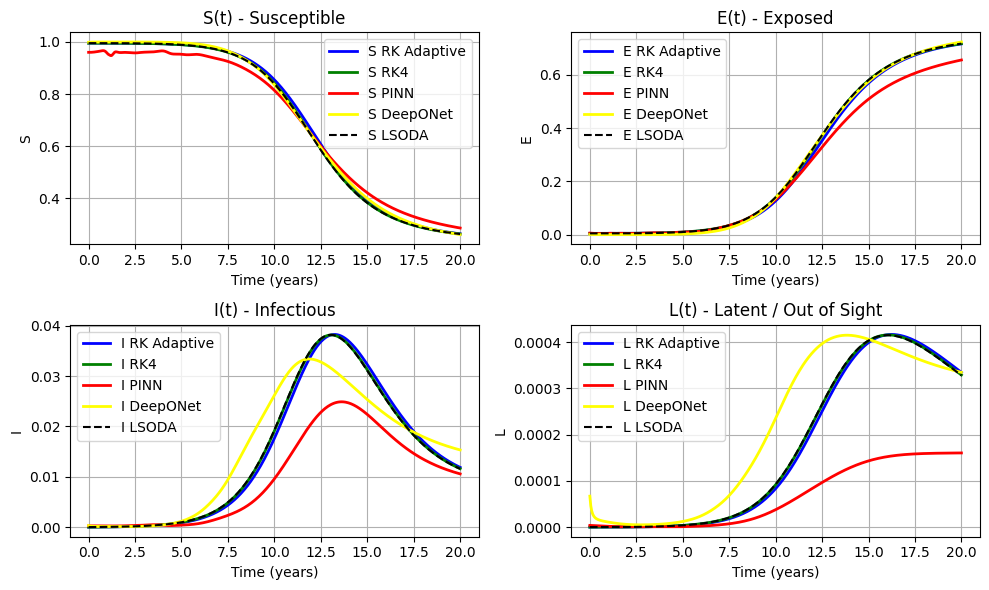

In [ ]:
import pickle
time_true = time_domain
lamda = 2
mu = 0.0101
df = generate_reference_solution(time_true,lamda, mu)
time_true = df['Time'].values.astype(np.float32)
S_true = df['S'].values
E_true = df['E'].values
I_true = df['I'].values
L_true = df['L'].values

Solution_Rk4 = PredictMultipleICsUsingRK4(time_true, [[lamda, mu]])[0]
S_rk4 = Solution_Rk4[0]
E_rk4 = Solution_Rk4[1]
I_rk4 = Solution_Rk4[2]
L_rk4 = Solution_Rk4[3]

Solution_RkAdaptive, times_rk_adaptive = PredictMultipleICsUsingAdaptiveRK([[lamda, mu]])
Solution_RkAdaptive = Solution_RkAdaptive[0]
times_rk_adaptive = times_rk_adaptive[0]
S_rkAdaptive = Solution_RkAdaptive[0]
E_rkAdaptive = Solution_RkAdaptive[1]
I_rkAdaptive = Solution_RkAdaptive[2]
L_rkAdaptive = Solution_RkAdaptive[3]

Solution_PINN = PredictSeveralICsUsingPINN([[lamda, mu]], time_true)[0]
S_PINN = Solution_PINN[0]
E_PINN = Solution_PINN[1]
I_PINN = Solution_PINN[2]
L_PINN = Solution_PINN[3]

Solution_DeepONet = PredictSeveralICsUsingDeepONet([[lamda, mu]], time_true)[0]
S_DeepONet = Solution_DeepONet[0]
E_DeepONet = Solution_DeepONet[1]
I_DeepONet = Solution_DeepONet[2]
L_DeepONet = Solution_DeepONet[3]

#S_LSTM = Solution_DeepONet[0]
#E_LSTM = Solution_DeepONet[1]
#I_LSTM = Solution_DeepONet[2]
#L_LSTM = Solution_DeepONet[3]

#with open('LSTMSol.pkl', 'rb') as file:
#  loaded_object = pickle.load(file)
#  S_LSTM = loaded_object[0]
#  E_LSTM = loaded_object[1]
#  I_LSTM = loaded_object[2]
#  L_LSTM = loaded_object[3]

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(times_rk_adaptive, S_rkAdaptive, label='S RK Adaptive', color='b', linewidth=2)
plt.plot(time_true, S_rk4, label='S RK4', color='g', linewidth=2)
plt.plot(time_true, S_PINN, label='S PINN', color='r', linewidth=2)
plt.plot(time_true, S_DeepONet, label='S DeepONet', color='yellow', linewidth=2)
#plt.plot(time_true[16:], S_LSTM, label='S LSTM', color='orange', linewidth=2)
plt.plot(time_true, S_true, label='S LSODA', linestyle='--', color='black')
plt.title('S(t) - Susceptible')
plt.xlabel('Time (years)')
plt.ylabel('S')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(times_rk_adaptive, E_rkAdaptive, label='E RK Adaptive', color='b', linewidth=2)
plt.plot(time_true, E_rk4, label='E RK4', color='g', linewidth=2)
plt.plot(time_true, E_PINN, label='E PINN', color='r', linewidth=2)
plt.plot(time_true, E_DeepONet, label='E DeepONet', color='yellow', linewidth=2)
#plt.plot(time_true[16:], E_LSTM, label='E LSTM', color='orange', linewidth=2)
plt.plot(time_true, E_true, label='E LSODA', linestyle='--', color='black')
plt.title('E(t) - Exposed')
plt.xlabel('Time (years)')
plt.ylabel('E')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(times_rk_adaptive, I_rkAdaptive, label='I RK Adaptive', color='b', linewidth=2)
plt.plot(time_true, I_rk4, label='I RK4', color='g', linewidth=2)
plt.plot(time_true, I_PINN, label='I PINN', color='r', linewidth=2)
plt.plot(time_true, I_DeepONet, label='I DeepONet', color='yellow', linewidth=2)
#plt.plot(time_true[16:], I_LSTM, label='I LSTM', color='orange', linewidth=2)
plt.plot(time_true, I_true, label='I LSODA', linestyle='--', color='black')
plt.title('I(t) - Infectious')
plt.xlabel('Time (years)')
plt.ylabel('I')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(times_rk_adaptive, L_rkAdaptive, label='L RK Adaptive', color='b', linewidth=2)
plt.plot(time_true, L_rk4, label='L RK4', color='g', linewidth=2)
plt.plot(time_true, L_PINN, label='L PINN', color='r', linewidth=2)
plt.plot(time_true, L_DeepONet, label='L DeepONet', color='yellow', linewidth=2)
#plt.plot(time_true[16:], L_LSTM, label='L LSTM', color='orange', linewidth=2)
plt.plot(time_true, L_true, label='L LSODA', linestyle='--', color='black')
plt.title('L(t) - Latent / Out of Sight')
plt.xlabel('Time (years)')
plt.ylabel('L')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()